## Goal
- Make 2D mask numpy files for each slice

In [23]:
import numpy as np
import os
import time
import glob
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import pickle

In [24]:
# class indices

LARGE_BOWEL = 0
SMALL_BOWEL = 1
STOMACH = 2
MASK_INDICES = {'large_bowel': LARGE_BOWEL, 'small_bowel':SMALL_BOWEL, 'stomach':STOMACH}

In [25]:
# Taking a look at the dataset
df_train = pd.read_csv('./input/uw-madison-gi-tract-image-segmentation/train.csv')
print(df_train.shape)
df_train.head(4)

(115488, 3)


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN


In [26]:
#unique ids
ids = np.unique(df_train[df_train['segmentation'].notna()]['id'].str.split('_day').apply(lambda x : x[0]).apply(lambda x: x.split('case')[1]).to_list())
print(ids.shape)
print(ids[:10])

(85,)
['101' '102' '107' '108' '11' '110' '111' '113' '114' '115']


In [27]:
# rle decode function

def rle_decode(mask_rle, shape):
    h, w = shape
    img = np.zeros((h * w,), dtype=np.float32)
    if isinstance(mask_rle, str) and len(mask_rle) > 0:
        s = np.array(mask_rle.split(), dtype=int)
        starts = s[0::2] - 1
        lengths = s[1::2]
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            img[lo : hi] = 1

    return img.reshape(shape).astype(np.uint8)

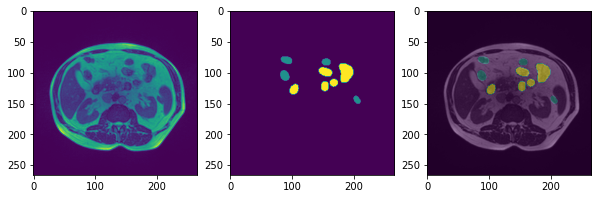

In [42]:
# takin a look at a slice of one sample and its mask
train_path = './input/uw-madison-gi-tract-image-segmentation/train'
case= 154
day = 16
slice_num=75
df_rows = df_train[df_train['id'] == f'case{case}_day{day}_slice_{str(slice_num).zfill(4)}']
image_path = glob.glob(f'{train_path}/case{case}/case{case}_day{day}/scans/slice_{str(slice_num).zfill(4)}_*.png')[0]
image = plt.imread(image_path)
mask1 = rle_decode(df_rows['segmentation'].iloc[0], image.shape)
mask2 = rle_decode(df_rows['segmentation'].iloc[1], image.shape) * 2
mask3 = rle_decode(df_rows['segmentation'].iloc[2], image.shape) * 3
mask = mask1 + mask2 + mask3
fig, ax = plt.subplots(1,3,figsize=(10,6))
ax[0].imshow(image)
ax[1].imshow(mask)
ax[2].imshow(image,'gray')
ax[2].imshow(mask, alpha=0.5)
plt.show()

In [38]:
mask3 = rle_decode(df_rows['segmentation'].iloc[2], image.shape)

In [39]:
mask3.sum()

962

In [12]:
image.shape

(266, 266)

In [32]:
# check if any day in case have slice with different sizes

multi_size_sliced_case_day = []
num_slices_count = dict()
for root, dirs, files in sorted(os.walk(train_path)):
    if not files:
        continue
        
    if 'mask' in root:
        continue
    
    case_day = root.split('\\')[-1]
    files = sorted(files)
    image_values = [item.replace('.png', '').split('_')[2:] for item in files]
    image_sizes = np.float32(image_values)
    unique_sizes = np.unique(image_sizes, axis=0)
    
    max_slice = int(files[-1].split('_')[1])
    if max_slice not in num_slices_count:
        num_slices_count[max_slice] = 0
    
    num_slices_count[max_slice] += 1
    
    """
    for row in unique_sizes:
        print(f'{case_day}: image physical size: {row[1]*row[3]} * {row[0]*row[2]}  image resolution {int(row[1])} * {int(row[0])}')
    """
    if len(unique_sizes) != 1:
        multi_size_sliced_case_day.append(case_day)

if multi_size_sliced_case_day:
    print(f'\ncase-day with multi sized slices: {multi_size_sliced_case_day}')
else:
    print('\nno multi sized case-day!')
    
print(f'unique number of slices : {num_slices_count}')


no multi sized case-day!
unique number of slices : {144: 259, 80: 15}


In [26]:
# create separate mask files for each class
prev_case_name = ''
for index, row in df_train.iterrows():
    row_id , mask_class, segmentation = row['id'], row['class'], row['segmentation']
    id_values = row_id.split('_')
    case_name = id_values[0]
    save_dir = os.path.join(train_path, id_values[0], id_values[0] + '_' + id_values[1], 'masks')
    # os.makedirs(save_dir, exist_ok=True)
    
    image_path = save_dir.replace('masks', 'scans')
    files = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]
    if not files:
        continue
    
    dim2, dim1 = np.int32(files[0].split('_')[2:4])
    mask_class = mask_class.replace('_', '-')
    np_file_name = f'{row_id}_{mask_class}'
    
    mask = rle_decode(segmentation, (dim1, dim2))
    np.save(os.path.join(save_dir, np_file_name), mask, allow_pickle=True)
    
    if prev_case_name and prev_case_name != case_name:
        print(f'{prev_case_name} masks are saved')
    
    prev_case_name = case_name
    

case123 masks are saved
case77 masks are saved
case133 masks are saved
case129 masks are saved
case139 masks are saved
case130 masks are saved
case88 masks are saved
case44 masks are saved
case145 masks are saved
case15 masks are saved
case110 masks are saved
case42 masks are saved
case118 masks are saved
case66 masks are saved
case91 masks are saved
case142 masks are saved
case58 masks are saved
case63 masks are saved
case114 masks are saved
case102 masks are saved
case115 masks are saved
case65 masks are saved
case53 masks are saved
case122 masks are saved
case125 masks are saved
case117 masks are saved
case140 masks are saved
case134 masks are saved
case9 masks are saved
case113 masks are saved
case90 masks are saved
case49 masks are saved
case19 masks are saved
case6 masks are saved
case67 masks are saved
case154 masks are saved
case135 masks are saved
case84 masks are saved
case147 masks are saved
case101 masks are saved
case7 masks are saved
case119 masks are saved
case32 masks a

In [8]:
# create one mask file for each slice scan
prev_case_name = ''
for row_id, grouped in df_train.groupby('id'):
    id_values = row_id.split('_')
    case_name = id_values[0]
    save_dir = os.path.join(train_path, id_values[0], id_values[0] + '_' + id_values[1], 'masks2D')
    os.makedirs(save_dir, exist_ok=True)
    image_path = save_dir.replace('masks2D', 'scans')
    files = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]
    if not files:
        continue
    
    dim2, dim1 = np.int32(files[0].split('_')[2:4])
    mask = np.zeros((dim1, dim2, 3), dtype=np.uint8)
    
    for row_index, row in grouped.iterrows():
        mask_class, segmentation = row['class'], row['segmentation']
        mask_index = MASK_INDICES[mask_class]
        
        mask[:,:,mask_index] = rle_decode(segmentation, (dim1, dim2))
    
    np.save(os.path.join(save_dir, row_id), mask, allow_pickle=True)
    
    if prev_case_name and prev_case_name != case_name:
        print(f'{prev_case_name} masks are saved')
    
    prev_case_name = case_name

case101 masks are saved
case102 masks are saved
case107 masks are saved
case108 masks are saved
case110 masks are saved
case111 masks are saved
case113 masks are saved
case114 masks are saved
case115 masks are saved
case116 masks are saved
case117 masks are saved
case118 masks are saved
case119 masks are saved
case11 masks are saved
case121 masks are saved
case122 masks are saved
case123 masks are saved
case124 masks are saved
case125 masks are saved
case129 masks are saved
case130 masks are saved
case131 masks are saved
case133 masks are saved
case134 masks are saved
case135 masks are saved
case136 masks are saved
case138 masks are saved
case139 masks are saved
case140 masks are saved
case141 masks are saved
case142 masks are saved
case143 masks are saved
case144 masks are saved
case145 masks are saved
case146 masks are saved
case147 masks are saved
case148 masks are saved
case149 masks are saved
case154 masks are saved
case156 masks are saved
case15 masks are saved
case16 masks are s

./input/uw-madison-gi-tract-image-segmentation/train/case154/case154_day16/masks2D/case154_day16_slice_0075_*.npy


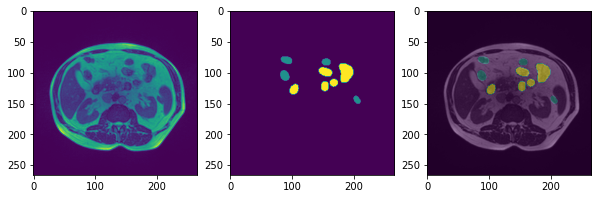

In [25]:
# check if files are created correctly
case= 154
day = 16
slice_num=75
df_rows = df_train[df_train['id'] == f'case{case}_day{day}_slice_{str(slice_num).zfill(4)}']
image_path = glob.glob(f'{train_path}/case{case}/case{case}_day{day}/scans/slice_{str(slice_num).zfill(4)}_*.png')[0]
image = plt.imread(image_path)
print(f'{train_path}/case{case}/case{case}_day{day}/masks2D/case{case}_day{day}_slice_{str(slice_num).zfill(4)}_*.npy')
mask_path = glob.glob(f'{train_path}/case{case}/case{case}_day{day}/masks2D/case{case}_day{day}_slice_{str(slice_num).zfill(4)}.npy')[0]
mask = np.load(mask_path)
mask[:,:,1] *= 2
mask[:,:,2] *= 3
mask = mask.sum(axis=2)
fig, ax = plt.subplots(1,3,figsize=(10,6))
ax[0].imshow(image)
ax[1].imshow(mask)
ax[2].imshow(image,'gray')
ax[2].imshow(mask, alpha=0.5)
plt.show()

In [34]:
# create case-day column
df_train['case_day'] = df_train['id'].map(lambda x: x.split('_slice')[0])

In [35]:
df_train.head(4)

,id,class,segmentation,case_day
0,case123_day20_slice_0001,large_bowel,NaN,case123_day20
1,case123_day20_slice_0001,small_bowel,NaN,case123_day20
2,case123_day20_slice_0001,stomach,NaN,case123_day20
3,case123_day20_slice_0002,large_bowel,NaN,case123_day20


In [36]:
# create 3d mask for each case-day
for case_day, grouped in df_train.groupby('case_day'):
    case_name = case_day.split('_')[0]
    save_dir = os.path.join(train_path, case_name, case_day, 'masks3D')
    os.makedirs(save_dir, exist_ok=True)
    image_path = save_dir.replace('masks3D', 'scans')
    files = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]
    if not files:
        continue
        
    max_slice = 0
    for file in files:
        max_slice = max(max_slice, int(file.split('_')[1]))
    
    dim2, dim1 = np.int32(files[0].split('_')[2:4])
    mask = np.zeros((dim1, dim2, max_slice, 3), dtype=np.uint8)
    
    for row_index, row in grouped.iterrows():
        mask_class, segmentation = row['class'], row['segmentation']
        mask_index = MASK_INDICES[mask_class]
        slice_index = int(row['id'].split('slice_')[1]) - 1
        
        mask[:, :, slice_index, mask_index] = rle_decode(segmentation, (dim1, dim2))
    
    print(f'{case_day} saved, shape- {mask.shape}, mask sum = {mask.sum(axis=(0,1,2))}')
    np.save(os.path.join(save_dir, case_day), mask, allow_pickle=True)
    
    
    prev_case_name = case_name

case101_day20 saved, shape- (266, 266, 144, 3), mask sum = [58648 38530 56561]
case101_day22 saved, shape- (266, 266, 144, 3), mask sum = [111968  87560  46901]
case101_day26 saved, shape- (266, 266, 144, 3), mask sum = [101438  86278  31886]
case101_day32 saved, shape- (266, 266, 144, 3), mask sum = [60543 66672 68253]
case102_day0 saved, shape- (310, 360, 144, 3), mask sum = [41630 20465 30713]
case107_day0 saved, shape- (266, 266, 144, 3), mask sum = [82257 47887 87651]
case107_day19 saved, shape- (266, 266, 144, 3), mask sum = [115625 171746 148659]
case107_day21 saved, shape- (266, 266, 144, 3), mask sum = [ 66347 142184  68713]
case108_day0 saved, shape- (266, 266, 144, 3), mask sum = [127671 121809 133838]
case108_day10 saved, shape- (266, 266, 144, 3), mask sum = [116530 104473  33318]
case108_day13 saved, shape- (266, 266, 144, 3), mask sum = [ 78480 112818  29294]
case110_day12 saved, shape- (310, 360, 144, 3), mask sum = [ 41856 187777  41137]
case110_day16 saved, shape- (31

./input/uw-madison-gi-tract-image-segmentation/train/case154/case154_day16/masks2D/case154_day16_slice_0075_*.npy
mask sum 1886


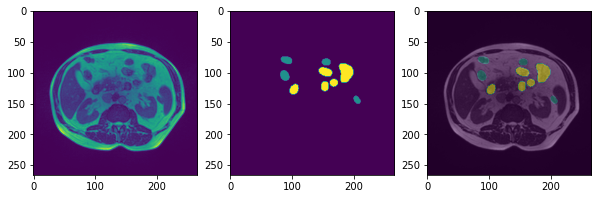

In [41]:
# check if files are created correctly
case= 154
day = 16
slice_num=75
df_rows = df_train[df_train['id'] == f'case{case}_day{day}_slice_{str(slice_num).zfill(4)}']
image_path = glob.glob(f'{train_path}/case{case}/case{case}_day{day}/scans/slice_{str(slice_num).zfill(4)}_*.png')[0]
image = plt.imread(image_path)
print(f'{train_path}/case{case}/case{case}_day{day}/masks2D/case{case}_day{day}_slice_{str(slice_num).zfill(4)}_*.npy')
mask_path = glob.glob(f'{train_path}/case{case}/case{case}_day{day}/masks3D/case{case}_day{day}.npy')[0]
mask = np.load(mask_path)
mask = mask[:, :, slice_num - 1]
print(f'mask sum {mask.sum()}')
mask[:,:, 1] *= 2
mask[:,:, 2] *= 3
mask = mask.sum(axis=2)
fig, ax = plt.subplots(1,3,figsize=(10,6))
ax[0].imshow(image)
ax[1].imshow(mask)
ax[2].imshow(image,'gray')
ax[2].imshow(mask, alpha=0.5)
plt.show()

In [17]:
a = np.zeros((3,4,5,3))

In [18]:
a[0][0][0][1] = 2

In [22]:
a.sum(axis=(0,1,2))

array([0., 2., 0.])